# Inner mechanics of the SPAED algorithm

In [1]:
from spaed import spaed, spaed_, load_pae, get_delineations, map_cols
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Here is the example endolysin we will be working with.

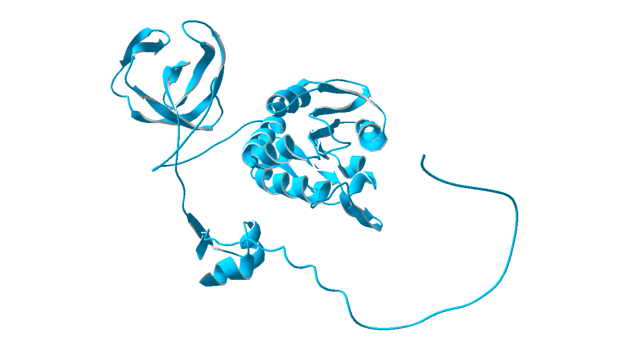

In [2]:
plt.figure(figsize=(8,8))
with open("article/algo_example/example_lysin.png", 'rb') as f:
    im = plt.imread(f)
plt.imshow(im)
plt.axis('off')
plt.show()

## Preprocessing
SPAED takes as input the **PAE matrix** obtained from AlphaFold.

The matrix is normalized to make it symmetric:

$pae_{norm} = \frac{(pae + pae^{T})}{2}$

In [18]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

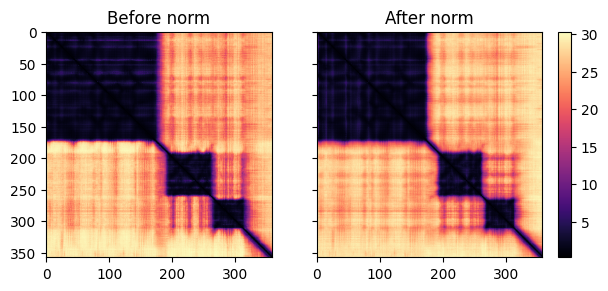

In [29]:
with open("article/algo_example/example.json") as f:
    data = json.load(f)
pae = np.array(data["predicted_aligned_error"])

pae_norm = (pae + pae.T) / 2 #make matrix symmetrical


f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(pae, cmap="magma")
ax1.set_title('Before norm')
im = ax2.imshow(pae_norm, cmap="magma")
ax2.set_title('After norm')

cax = f.add_axes([ax2.get_position().x1+0.025, ax2.get_position().y0, 0.02, ax2.get_position().y1-ax2.get_position().y0])
cbar = f.colorbar(im, cax=cax)
plt.show()

## Step 1: Hierarchical clustering

Hierarchical clustering (scipy.cluster.hierarchy.fclusterdata) is performed on the normalized matrix. The maximum number of clusters is set to 1/10<sup>th</sup> of the length of the protein, so in this case to 35 clusters. This step places the most similar columns of the PAE matrix into the same clusters.

The article refers to the **profile** of a residue in the PAE matrix. The profile of a residue is obtained by taking all the values in its corresponding column of the PAE matrix. Residues in the same domain should have similar profiles. Also, notice that within a domain, residues mostly have a PAE score <=5.

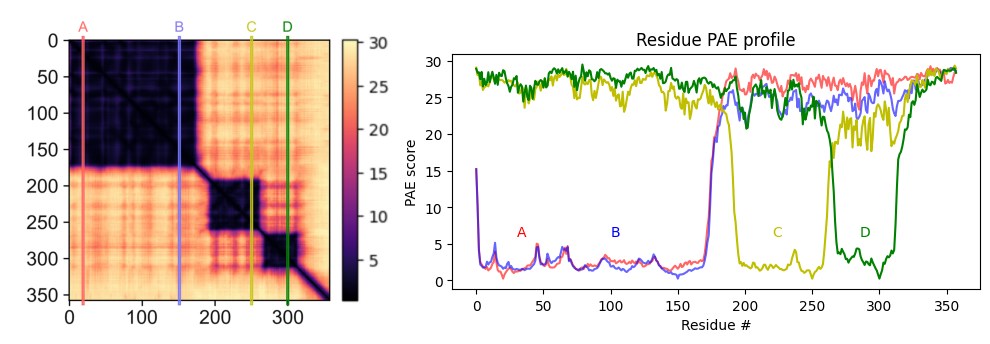

In [59]:
from matplotlib import gridspec
plt.figure(figsize=(10,10))
ax1 = plt.subplot2grid((7, 7), loc=(3, 0), colspan=3, rowspan=4)
ax2 = plt.subplot2grid((7, 7), loc=(4, 3), colspan=4, rowspan=2)

with open("article/algo_example/profiles.png", 'rb') as f:
    im = plt.imread(f)
ax1.imshow(im)
ax1.axis('off')

ax2.plot(pae_norm[20,:], 'r', alpha=0.6)
ax2.plot(pae_norm[150,:], 'b', alpha=0.6)
ax2.plot(pae_norm[250,:], 'y', alpha=1)
ax2.plot(pae_norm[300,:], 'g', alpha=1)
ax2.text(30, 6, 'A', c='r'); plt.text(100, 6, 'B', c='b'); plt.text(220, 6, 'C', c='y'); plt.text(285, 6, 'D', c='g')
ax2.set_ylabel("PAE score"); ax2.set_xlabel("Residue #")
ax2.set_title('Residue PAE profile')

plt.tight_layout()
#plt.savefig("profiles4.png")
plt.show()

Applying the clustering algorithm yields the following result, where each colour corresponds to a different assigned cluster.

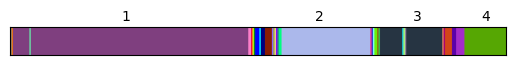

In [5]:
import scipy.cluster.hierarchy as hcluster
clusters = hcluster.fclusterdata(pae_norm, len(pae_norm)//10, criterion="maxclust")
cols = map_cols(clusters, len(np.unique(clusters)), form=False)

plt.imshow([cols, cols], aspect=10)
plt.xticks([]); plt.yticks([])
plt.text(80, -1, '1'); plt.text(220, -1, '2'); plt.text(290, -1, '3'); plt.text(340, -1, '4');
plt.show()

At first glance, we can already see 4 clusters, each containing many residues.

Notice how residues in linker regions are assigned to many small clusters. This is a result of the high number of clusters (in this case 35) that the clustering algorithm is allowed to look for. In contrast, long, continuous clusters are assigned to more homogeneous regions of the PAE matrix.

## Step 2: Domain detection
Clusters with 25 or more residues are assigned as domains. This threshold was chosen as domains are expected to have at least 30 residues. A little buffer is given for errors present in the preliminary assignment of clusters.

Each identified domain is assigned a new cluster number (1-4 in this case) whereas all other residues are assigned a 'non-domain' id.

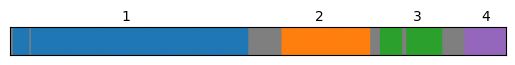

In [6]:
new_clusters = []
for i in clusters:
    if i not in [31, 16, 21, 10]:
        new_clusters += [-1]
    else:
        new_clusters += [i]
cols = map_cols(new_clusters, len(np.unique(clusters)), form=True)

plt.imshow([cols, cols], aspect=10)
plt.xticks([]); plt.yticks([])
plt.text(80, -1, '1'); plt.text(220, -1, '2'); plt.text(290, -1, '3'); plt.text(340, -1, '4');
plt.show()

## Step 3: N- and C-terminal correction
Next, we correct the ends of the sequences. These regions often possess residues that are freer to move and thus have a profile in the PAE matrix that is very different from residues in the domain they are nearest to. If this region is very short (<20 residues), it is simply concatenated to the nearest domain (like the first residue in this example).

Endolysins can also possess signal peptides in N- or C-terminal which correspond to longer (~25 residues) disordered regions. These are interesting to flag for future studies. In the PAE matrix, these disordered regions can be identified by looking for low PAE score 'diagonals'. In practice, we can count the number of 'dark' squares (PAE score <5) in every column (see figure 3 for the reason for using PAE score <5). This gives a good estimation of the packing of the protein in any given region as it reflects the number of residues that are close in space to any given residue. More importantly, residues in less packed regions such as linkers or end-terminal disordered regions will have very few of these 'dark' squares (i.e. they correspond to the 'diagonal' regions).

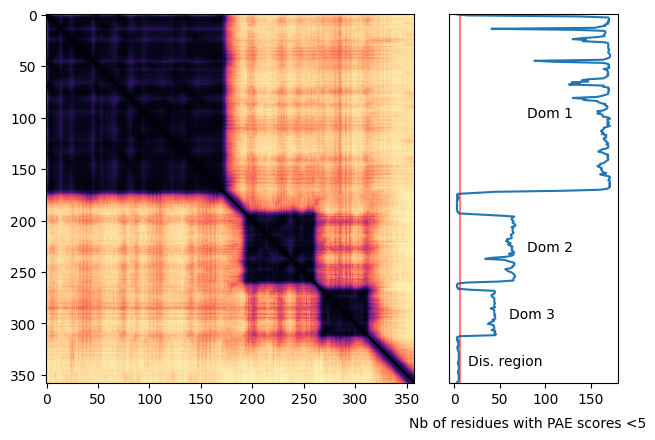

In [13]:
plt.figure(figsize=(10,10))
ax1 = plt.subplot2grid((4, 4), (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((4, 4), (0, 2), rowspan=2)

ax1.imshow(pae_norm, cmap="magma")
ax2.plot((pae_norm < 4).sum(axis=1), list(range(len(pae_norm))))
ax2.set_yticks([])
ax2.margins(y=0)
plt.gca().invert_yaxis()
ax2.text(80, 100, 'Dom 1'); ax2.text(80, 230, 'Dom 2'); ax2.text(60, 295, 'Dom 3'); ax2.text(15, 340, 'Dis. region');
ax2.axvline(x = 6, color = 'r', label = 'cutoff', alpha=0.5)


plt.text(-50, 400, 'Nb of residues with PAE scores <5')
#plt.savefig("correction2.png")
plt.show()

If more than 80% of residues in a region are below the cutoff (red line in the graph above) corresponding to 6 residues with scores < 5, the region is considered to be disordered.

The new assignment yields the following, where the 4th region, now in red, is flagged as being disordered.

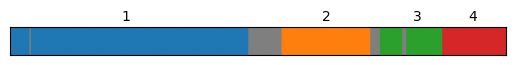

In [59]:
clusters = spaed_(pae_norm, form=True, plot=False, ends=True, artifacts=False, linkers=False)
cols = map_cols(clusters, len(np.unique(clusters)), form=True)

plt.imshow([cols, cols], aspect=10)
plt.xticks([]); plt.yticks([])
plt.text(80, -1, '1'); plt.text(225, -1, '2'); plt.text(290, -1, '3'); plt.text(330, -1, '4');
plt.show()

## Step 4: Artifact removal
We correct small artifacts originating from the initial assignment of clusters by scanning for residues assigned as 'non-domain' within a domain. This fixes the wrongly assigned residues like in domain 3.

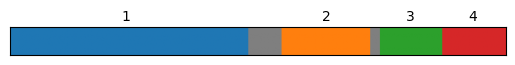

In [61]:
clusters = spaed_(pae_norm, form=True, plot=False, ends=True, artifacts=True, linkers=False)
cols = map_cols(clusters, len(np.unique(clusters)), form=True)

plt.imshow([cols, cols], aspect=10)
plt.xticks([]); plt.yticks([])
plt.text(80, -1, '1'); plt.text(225, -1, '2'); plt.text(285, -1, '3'); plt.text(330, -1, '4');
plt.show()

## Step 5: Linker adjustment
Finally, we adjust the length of linkers. This step is necessary to correct small mistakes at the domain/linker interface that can originate from the initial clustering.

Residues near the domain/linker boundary are considered part of the domain if they have a low PAE score (<5) with at least 25 residues (a domain is expected to be at least 30 residues long) as residues found in a domain should have a low PAE score with about as many residues as are part of that domain.

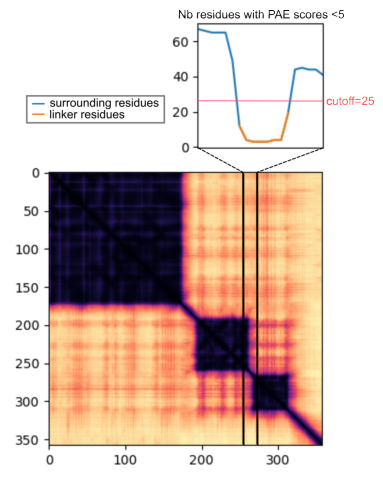

In [51]:
"""
plt.figure(figsize=(10,10))
ax1 = plt.subplot2grid((5, 5), (1, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((5, 5), (0, 1), colspan=1)

ax1.imshow(pae_norm, cmap="magma")
ax1.axvline(x = 254, color = 'black', label = 'linker_l', alpha=0.5)
ax1.axvline(x = 273, color = 'black', label = 'linker_l', alpha=0.5)

ax2.plot(b)
ax2.plot(a)
ax2.set_xticks([])
ax2.margins(x=0)

plt.savefig("article/algo_example/temp.png")
plt.show()
"""
plt.figure(figsize=(6,6))
with open("article/algo_example/linkers.png", 'rb') as f:
    im = plt.imread(f)
plt.imshow(im)
plt.axis('off')
plt.show()

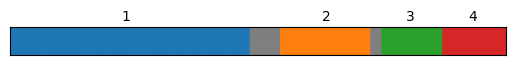

In [67]:
clusters = spaed_(pae_norm, form=True, plot=False, ends=True, artifacts=True, linkers=True, PAE_SCORE_CUTOFF=4)
cols = map_cols(clusters, len(np.unique(clusters)), form=True)

plt.imshow([cols, cols], aspect=10)
plt.xticks([]); plt.yticks([])
plt.show()

## Final result
Finally, we can see how the predicted domains look on the predicted 3D structure.

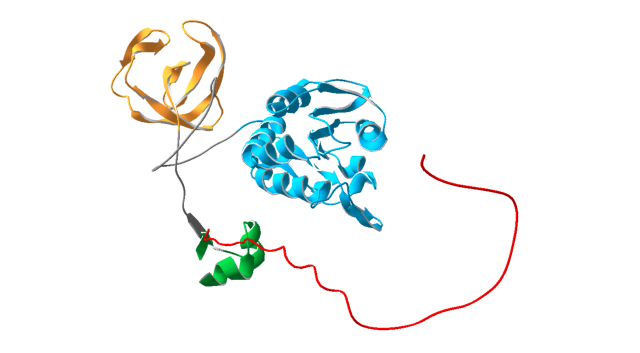

In [73]:
plt.figure(figsize=(8,8))
with open("article/algo_example/example_delin.png", 'rb') as f:
    im = plt.imread(f)
plt.imshow(im)
plt.axis('off')
plt.show()